In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, UpSampling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
def load_data(image_folder, mask_folder):
    images = []
    masks = []
    for filename in os.listdir(image_folder):
        img = cv2.imread(os.path.join(image_folder, filename))
        img = cv2.resize(img, (224, 224))  # Resize for ZFNet input size
        images.append(img)
        mask = cv2.imread(os.path.join(mask_folder, filename), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (112, 112))  # Resize to match model output size
        mask = np.expand_dims((mask > 127).astype(np.uint8), axis=-1)  # Convert to binary mask and add channel dimension
        masks.append(mask)
    return np.array(images), np.array(masks)


In [3]:
train_images, train_masks = load_data("/content/drive/MyDrive/DL_dataset/training_images", "/content/drive/MyDrive/DL_dataset/training_masks")
test_images, test_masks = load_data("/content/drive/MyDrive/DL_dataset/test_images", "/content/drive/MyDrive/DL_dataset/test_masks")

In [4]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [5]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(96, (7, 7), strides=(2, 2), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Upsampling layers
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=x)

In [6]:
model = create_model(input_shape=(224, 224, 3))

In [7]:
model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])

In [8]:
model.fit(train_images, train_masks, epochs=10, batch_size=8, validation_split=0.2)

Epoch 1/10
102/102 [==============================] - 535s 5s/step - loss: 0.6196 - accuracy: 0.6868 - val_loss: 0.5429 - val_accuracy: 0.7067
Epoch 2/10
102/102 [==============================] - 518s 5s/step - loss: 0.5263 - accuracy: 0.7403 - val_loss: 0.4981 - val_accuracy: 0.7533
Epoch 3/10
102/102 [==============================] - 523s 5s/step - loss: 0.4871 - accuracy: 0.7792 - val_loss: 0.4606 - val_accuracy: 0.7953
Epoch 4/10
102/102 [==============================] - 519s 5s/step - loss: 0.4937 - accuracy: 0.7747 - val_loss: 0.4491 - val_accuracy: 0.8041
Epoch 5/10
102/102 [==============================] - 519s 5s/step - loss: 0.4515 - accuracy: 0.7992 - val_loss: 0.4225 - val_accuracy: 0.8113
Epoch 6/10
102/102 [==============================] - 525s 5s/step - loss: 0.4351 - accuracy: 0.8110 - val_loss: 0.4191 - val_accuracy: 0.8278
Epoch 7/10
102/102 [==============================] - 531s 5s/step - loss: 0.4398 - accuracy: 0.8043 - val_loss: 0.4694 - val_accuracy: 0.7752

In [9]:
loss, accuracy = model.evaluate(test_images, test_masks)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

15/15 [==============================] - 87s 6s/step - loss: 0.4277 - accuracy: 0.8314
Test Loss: 0.42770764231681824
Test Accuracy: 0.8314030766487122


In [10]:
predicted_masks = model.predict(test_images)

15/15 [==============================] - 87s 6s/step


In [11]:
water_probability = np.mean(predicted_masks)
water_percentage = np.sum(predicted_masks) / np.sum(test_masks)

In [12]:
print("Water Probability:", water_probability)
print("Water Percentage:", water_percentage*10)

Water Probability: 0.2655822
Water Percentage: 7.9525122690726855


Image 1 - Water Probability: 0.18519198894500732


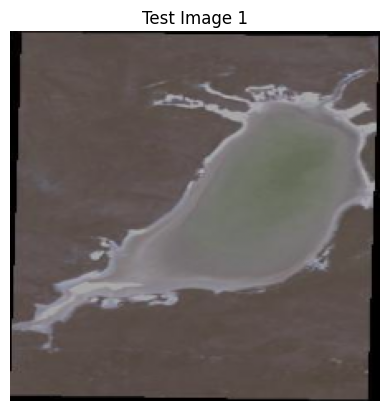

Image 2 - Water Probability: 0.40778300166130066


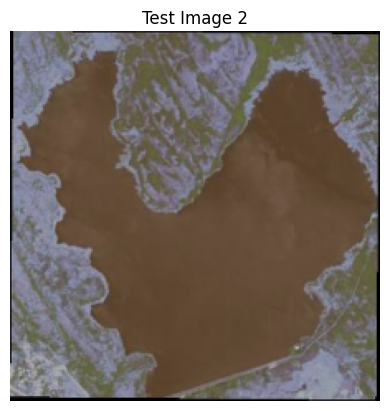

Image 3 - Water Probability: 0.2310696393251419


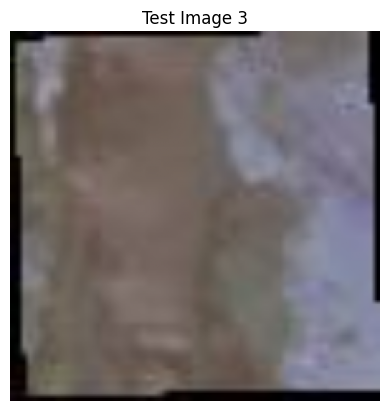

Image 4 - Water Probability: 0.24226588010787964


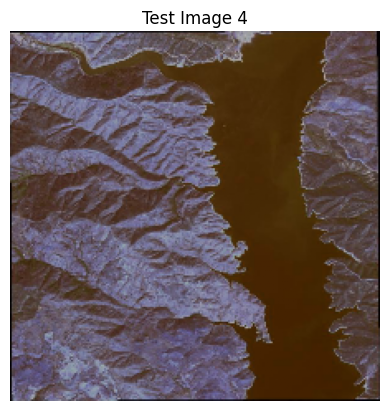

Image 5 - Water Probability: 0.05971315875649452


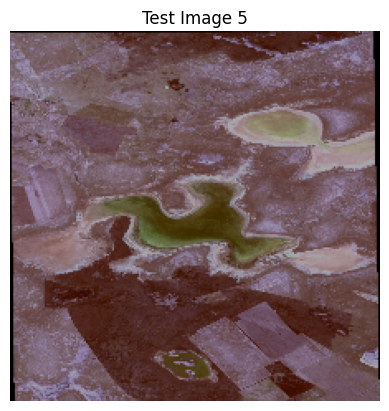

Image 6 - Water Probability: 0.1499490886926651


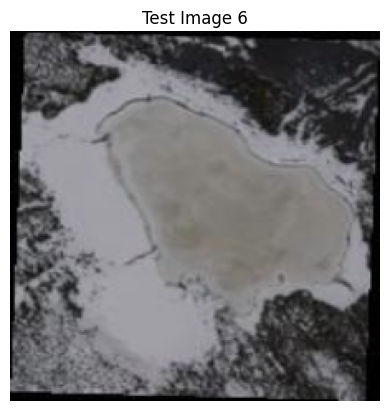

Image 7 - Water Probability: 0.5931447744369507


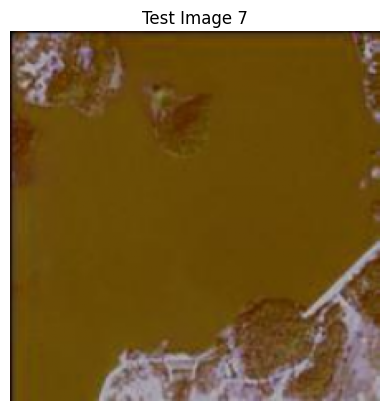

Image 8 - Water Probability: 0.1872774362564087


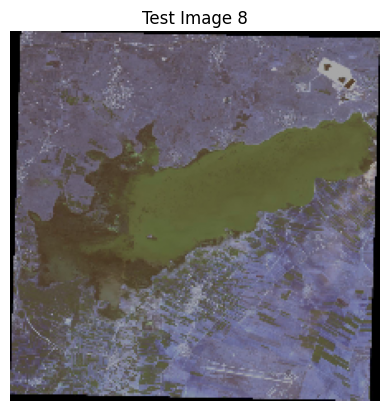

Image 9 - Water Probability: 0.20455756783485413


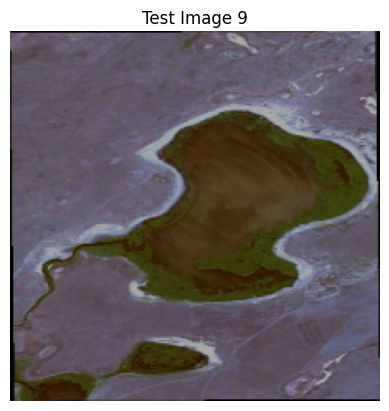

Image 10 - Water Probability: 0.1660320907831192


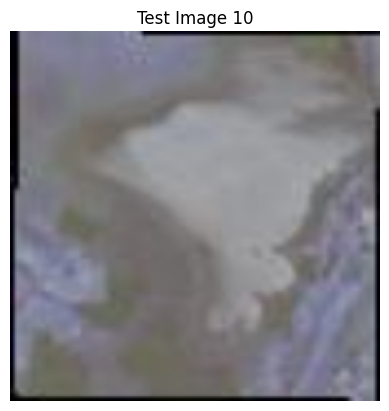

In [13]:
import matplotlib.pyplot as plt
for i in range(10):
    water_probability = np.mean(predicted_masks[i])
    print(f"Image {i+1} - Water Probability: {water_probability}")

    # Display the image
    plt.imshow(test_images[i])
    plt.title(f"Test Image {i+1}")
    plt.axis("off")
    plt.show()